### Курсовой проект для курса "Python для Data Science"

**Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).**

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки сдачи:
Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

from sklearn.metrics import r2_score

**Пути к директориям и файлам**

In [57]:
MODEL_DATASET_PATH = 'C:\\Users\\User\\Desktop\\py4dataS\\train.csv'
PREDICT_DATASET_PATH = 'C:\\Users\\User\\Desktop\\py4dataS\\test.csv'
PREPARED_DATASET_PATH = 'C:\\Users\\User\\Desktop\\py4dataS\\predictions.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [58]:
df = pd.read_csv(MODEL_DATASET_PATH)
df_pred = pd.read_csv(PREDICT_DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [59]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


### Обработка пропусков

In [60]:
def df_notnull(any_df):
    any_df.loc[any_df['LifeSquare'].isnull(), 'LifeSquare'] = any_df['LifeSquare'].median()
    any_df.loc[any_df['Healthcare_1'].isnull(), 'Healthcare_1'] = any_df['Healthcare_1'].median()
    return any_df

In [61]:
df_notnull(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [62]:
df_notnull(df_pred)
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     5000 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


### Обработка выбросов

In [63]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Square**

Жилая площадь не может быть меньше, чем общая

In [65]:
df.loc[((df['Square'] - df['LifeSquare']) < -5) == True] 
# если разница меньше 5м, скорее всего, ошибка ввода либо обработки пропусков и можно ею пренебречь,
# более - скорее всего, поменяли местами жилую и общую площадь

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,900.0,3,9,B,412511.088764
501,15923,27,1.0,26.553188,32.781260,0.0,25,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,114256.236153
590,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,900.0,0,2,B,141780.231857
900,8940,34,1.0,26.811587,32.781260,0.0,18,0.0,1977,0.069753,B,B,53,13670,4,900.0,1,11,B,175399.643453
1184,3902,23,1.0,27.442238,32.781260,1.0,4,4.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,65547.071846
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,900.0,0,1,B,97560.720383
3954,5210,27,1.0,27.245731,32.781260,1.0,8,16.0,2016,0.211401,B,B,9,1892,0,900.0,0,1,B,74982.605917
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,B,B,2,469,0,900.0,0,0,B,217357.492366
4638,4071,6,3.0,75.203314,82.486992,1.0,13,25.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B,211324.917957
6332,8961,27,1.0,33.398983,164.153360,6.0,3,5.0,1965,0.211401,B,B,9,1892,0,900.0,0,1,B,104891.073757


In [66]:
df.loc[((df['Square'] - df['LifeSquare']) < -5) == True, 'LifeSquare'] = df['Square']
df.loc[212, "Square"] = df.loc[212, "LifeSquare"]
df.loc[3280, "Square"] = df.loc[3280, "LifeSquare"]
df.loc[4328, "LifeSquare"] = df.loc[4328, "Square"]
df.loc[8030, "Square"] = df.loc[8030, "LifeSquare"]
df.loc[8437, "LifeSquare"] = df.loc[8437, "Square"]

In [68]:
df.loc[df['Square'] < 7] # самая маленькая из описанных квартир

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,5.497061,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,900.0,3,9,B,412511.088764
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3280,10527,27,1.0,4.380726,4.380726,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,900.0,0,1,B,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,900.0,0,1,B,161379.067034
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,181434.825589
8030,13265,1,3.0,4.823679,4.823679,0.0,6,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,237716.681261
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,900.0,1,11,B,458378.777006


In [69]:
df.loc[df['Square'] < 7, 'Square'] = df['Square']*10

In [70]:
df_pred.loc[((df_pred['Square'] - df_pred['LifeSquare']) < -5) == True] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
410,11533,94,2.0,48.713443,303.071094,6.0,5,12.0,1974,0.521867,B,B,25,6149,0,900.0,0,0,B
1436,12833,27,1.0,27.658462,32.925087,0.0,10,19.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B
4234,15846,34,1.0,26.719723,32.925087,1.0,4,2.0,2015,0.069753,B,B,53,13670,4,900.0,1,11,B
4713,170,6,2.0,2.900586,61.468563,1.0,18,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B


In [71]:
df_pred.loc[4713, "Square"] = df_pred.loc[4713, "LifeSquare"]
df_pred.loc[410, "LifeSquare"] = df_pred.loc[410, "Square"]

**year**

In [72]:
df[(df['HouseYear'] <= 1000) | (df['HouseYear'] > 2030)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [73]:
# обработаем вручную
df.loc[1497, "HouseYear"] = 2011
df.loc[4189, "HouseYear"] = 1968

In [74]:
df_pred[(df_pred['HouseYear'] <= 1000) | (df_pred['HouseYear'] > 2030)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


**Анализ целевой переменной**

In [75]:
df['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

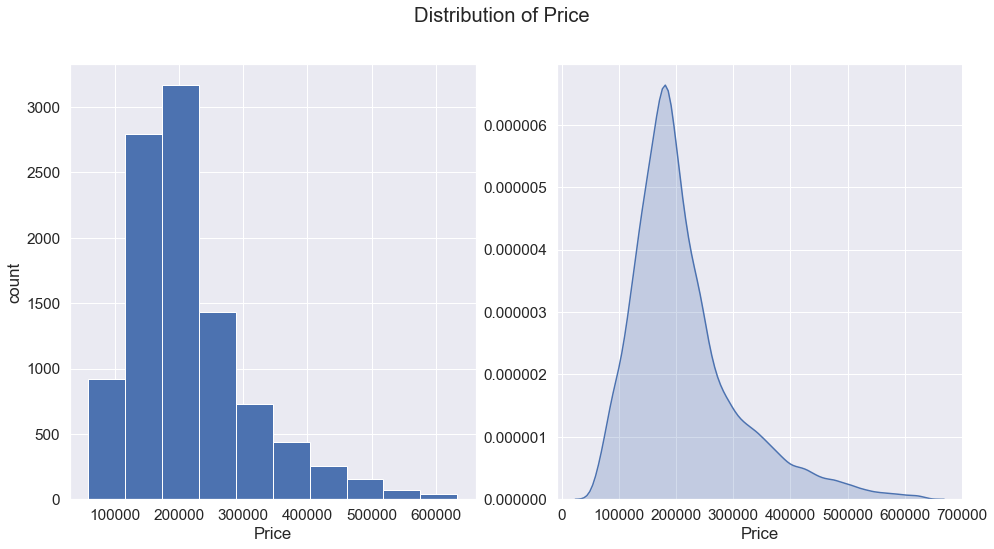

In [76]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show() # распределение вполне правдоподобное, без очевидых выбросов

In [77]:
target_mean = round(df['Price'].mean(), 2)
target_median = round(df['Price'].median(), 2)
target_mode = round(df['Price'].mode()[0], 2)

target_mean, target_median, target_mode

(214138.86, 192269.64, 59174.78)

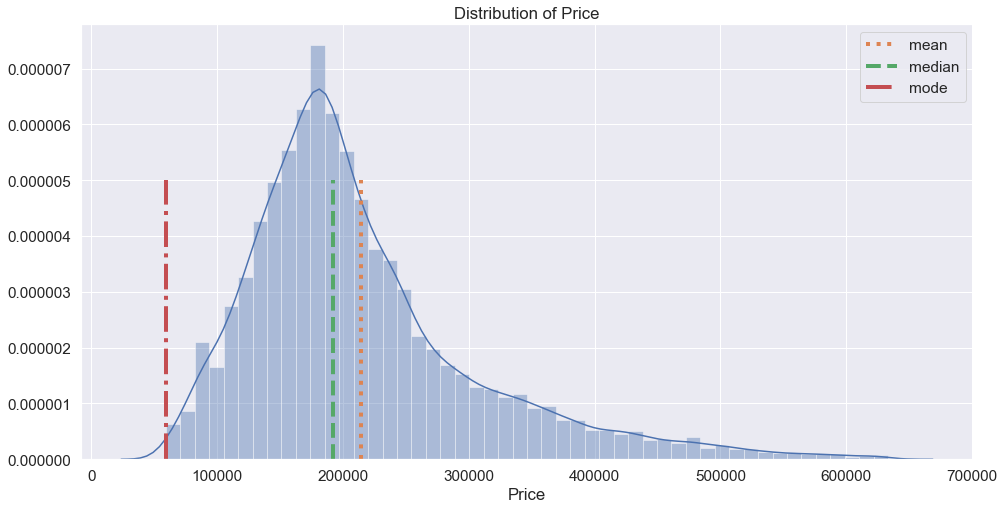

In [78]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean]*100 , y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median]*100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode]*100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show() # все значения встречаются по 1 разу, мода - первое (минимальное)

### Отбор и построение новых признаков

**Преобразуем категориальные признаки в бинарные**

In [79]:
def df_binars(any_df):
    any_df = pd.concat([any_df, pd.get_dummies(any_df['Ecology_2'])], axis=1)
    any_df = any_df.rename(columns = {'A':'Ecology_2_A', 'B': 'Ecology_2_B'})
    any_df = pd.concat([any_df, pd.get_dummies(any_df['Ecology_3'])], axis=1)
    any_df = any_df.rename(columns = {'A':'Ecology_3_A', 'B': 'Ecology_3_B'})
    any_df = pd.concat([any_df, pd.get_dummies(any_df['Shops_2'])], axis=1)
    any_df = any_df.rename(columns = {'A':'Shops_2_A', 'B': 'Shops_2_B'})
    return any_df

In [80]:
df = df_binars(df)
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

In [81]:
df_pred = df_binars(df_pred)

df_pred.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Ecology_2_A', 'Ecology_2_B',
       'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

**Распределение цены в зависимости от района.**
Обычно в любом городе существуют дешевые районы и дорогие, и от района зависит цена квадратного метра. 
Сгруппируем значения, отсортируем, введем переменную, которая будет возрастать вместе с ценой квадратного метра в районе, и построим график

In [82]:
price_sq_district = df.groupby(['DistrictId'], as_index=False).agg({'Square': 'sum', 'Price': 'sum'})
price_sq_district["Price_1sq"] = price_sq_district["Price"] / price_sq_district["Square"]
price_sq_district = price_sq_district.sort_values('Price_1sq')
price_sq_district['District_price_index'] = np.arange(0, 205)

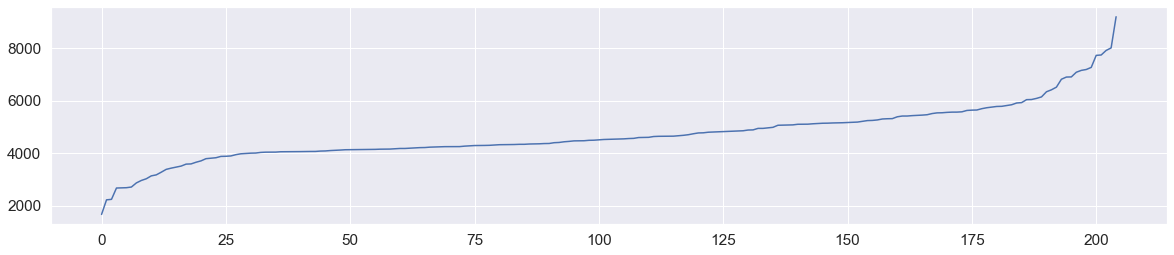

In [83]:
plt.figure(figsize=(20, 4))
x = price_sq_district['District_price_index']
y = price_sq_district['Price_1sq']
plt.plot(x, y)
plt.show()

In [84]:
price_sq_district.drop('Square', axis=1, inplace=True)
price_sq_district.drop('Price', axis=1, inplace=True)
price_sq_district.drop('Price_1sq', axis=1, inplace=True)

In [85]:
df = pd.merge(df, price_sq_district, on='DistrictId', how='left')
df_pred = pd.merge(df_pred, price_sq_district, on='DistrictId', how='left')

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 27 columns):
Id                      10000 non-null int64
DistrictId              10000 non-null int64
Rooms                   10000 non-null float64
Square                  10000 non-null float64
LifeSquare              10000 non-null float64
KitchenSquare           10000 non-null float64
Floor                   10000 non-null int64
HouseFloor              10000 non-null float64
HouseYear               10000 non-null int64
Ecology_1               10000 non-null float64
Ecology_2               10000 non-null object
Ecology_3               10000 non-null object
Social_1                10000 non-null int64
Social_2                10000 non-null int64
Social_3                10000 non-null int64
Healthcare_1            10000 non-null float64
Helthcare_2             10000 non-null int64
Shops_1                 10000 non-null int64
Shops_2                 10000 non-null object
Price               

**Интерквартильный размах**

In [87]:
df.Square.describe()

count    10000.000000
mean        56.355745
std         20.995512
min         11.368588
25%         41.784623
50%         52.519197
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [88]:
IQ=df.Square.describe()['75%']-df.Square.describe()['25%']
low_border=df.Square.describe()['25%']-IQ*1.5
high_border=df.Square.describe()['75%']+IQ*1.5
print(IQ,low_border,high_border)

24.116002246248243 5.610619630036204 102.07462861502918


In [89]:
df[(df['Square']<low_border)|(df['Square']>high_border)]  
# Значений площади, выходящих за интерквартильный размах, достаточно много, но скорее всего, это не выбросы, 
# а мало больших квартир - подавляющее большинство имеет высокие цены. Оставим как есть

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,District_price_index
19,4909,19,3.0,110.959792,56.996765,11.0,16,25.0,2012,0.000991,...,9,B,394895.325987,0,1,0,1,0,1,66
20,8862,0,3.0,103.605292,47.799426,10.0,12,17.0,2002,0.319809,...,8,B,521919.057400,0,1,0,1,0,1,17
23,6641,54,3.0,118.907612,32.781260,0.0,2,0.0,1977,0.006076,...,6,B,571069.052600,0,1,0,1,0,1,95
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,...,0,A,337299.867936,0,1,0,1,1,0,6
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,...,7,B,435462.048070,0,1,0,1,0,1,105
86,9613,148,3.0,127.481583,32.781260,1.0,16,1.0,2012,0.313925,...,10,B,510700.444735,0,1,0,1,0,1,97
132,3428,108,3.0,110.203969,59.270702,12.0,19,28.0,2007,0.019509,...,5,B,146061.730565,0,1,0,1,0,1,177
343,716,113,3.0,125.287183,127.477137,19.0,26,24.0,2017,0.050756,...,1,B,522197.035995,0,1,0,1,0,1,88
358,6006,62,3.0,121.844004,122.497641,1.0,3,3.0,1977,0.072158,...,0,A,193847.642016,0,1,0,1,1,0,4
386,13818,7,3.0,115.254741,56.404018,19.0,16,17.0,2012,0.035145,...,3,B,565355.938997,0,1,0,1,0,1,94


**Матрица корреляций**

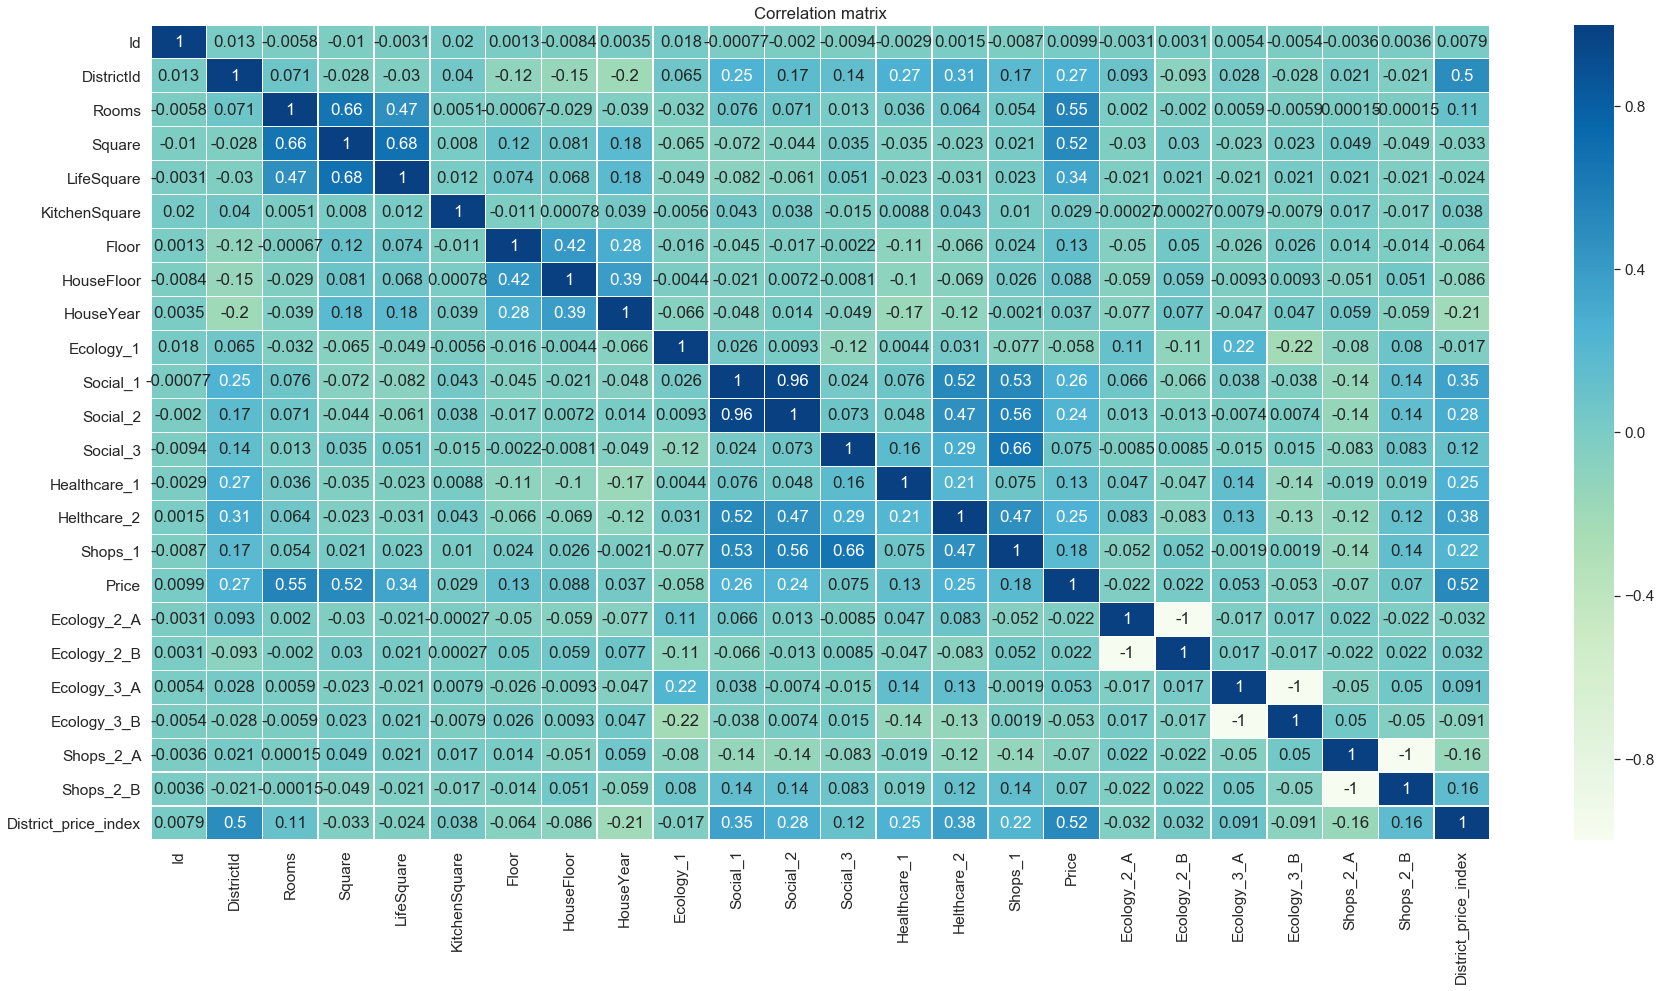

In [90]:
plt.figure(figsize = (30, 15))

sns.set(font_scale=1.4)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Подготовка к обучению**

In [91]:
y = df['Price']

In [93]:
def X_prepare(any_df): 
    X = any_df.copy()
    X.drop('Id', axis = 1, inplace = True)
    X.drop('Ecology_2', axis=1, inplace=True) # заменен бинарной переменной
    X.drop('Ecology_3', axis=1, inplace=True) # заменен бинарной переменной
    X.drop('Ecology_2_B', axis = 1, inplace = True) # колинеарен Ecology_2_A
    X.drop('Ecology_3_B', axis = 1, inplace = True) # колинеарен Ecology_3_A
    X.drop('Shops_2_B', axis = 1, inplace = True) # колинеарен Shops_2_A
    X.drop('Shops_2', axis=1, inplace=True) # заменен бинарной переменной
    X.drop('DistrictId', axis=1, inplace=True) # заменен показателем цены квадратного метра в районе
    #X.drop('LifeSquare', axis = 1, inplace = True) # данные неполные и входят в общую площадь, показателем можно пренебречь, но при расчетах не внижает показатели, оставлю
    X.drop('KitchenSquare', axis = 1, inplace = True) # данные имеют нулевые и неправдоподобно малые значения и слабо влияют на целевую переменную
    X.drop('Healthcare_1', axis = 1, inplace = True) # данные неполные и слабо влияют на целевую переменную
    X['Floor'] = X['Floor'].astype('float64')
    X['HouseYear'] = X['HouseYear'].astype('float64')
    X['Social_1'] = X['Social_1'].astype('float64')
    X['Social_2'] = X['Social_2'].astype('float64')
    X['Social_3'] = X['Social_3'].astype('float64')
    X['Helthcare_2'] = X['Helthcare_2'].astype('float64')
    X['Shops_1'] = X['Shops_1'].astype('float64')
    X['Ecology_2_A'] = X['Ecology_2_A'].astype('float64')
    X['Ecology_3_A'] = X['Ecology_3_A'].astype('float64')
    X['Shops_2_A'] = X['Shops_2_A'].astype('float64')
    X['District_price_index'] = X['District_price_index'].astype('float64')
    return X

In [94]:
X = X_prepare(df)

In [95]:
X.drop('Price', axis = 1, inplace = True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 16 columns):
Rooms                   10000 non-null float64
Square                  10000 non-null float64
LifeSquare              10000 non-null float64
Floor                   10000 non-null float64
HouseFloor              10000 non-null float64
HouseYear               10000 non-null float64
Ecology_1               10000 non-null float64
Social_1                10000 non-null float64
Social_2                10000 non-null float64
Social_3                10000 non-null float64
Helthcare_2             10000 non-null float64
Shops_1                 10000 non-null float64
Ecology_2_A             10000 non-null float64
Ecology_3_A             10000 non-null float64
Shops_2_A               10000 non-null float64
District_price_index    10000 non-null float64
dtypes: float64(16)
memory usage: 1.3 MB


In [96]:
X_pred = X_prepare(df_pred)

In [97]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Построение базовых моделей и выбор лучшей

**Линейная регрессия**

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
y_pred_lr = lr.predict(X_test)

In [ ]:
r2_score(y_test, y_pred_lr)

In [113]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [114]:
lr.fit(X_train_scaled, y_train)
y_pred_scaled = lr.predict(X_test_scaled)
r2_score(y_test, y_pred_scaled)

0.6060891039012714

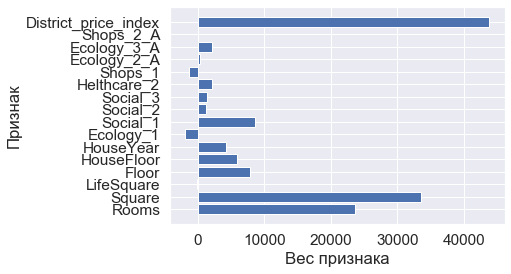

In [115]:
plt.barh(X_train.columns, lr.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

In [116]:
important_features = [
    feature
    for feature, weight in zip(X_train.columns, lr.coef_.flatten())
    if np.abs(weight) > 4000
]

print(important_features)

['Rooms', 'Square', 'Floor', 'HouseFloor', 'HouseYear', 'Social_1', 'District_price_index']


In [117]:
lr.fit(
    X_train_scaled.loc[:, important_features],
    y_train
)

y_pred_scaled_imp = lr.predict(X_test_scaled.loc[:, important_features])

r2_score(y_test, y_pred_scaled_imp) # показатель эффективности изменился незначительно,а при уменьшении количества признаков резко снижается

0.6043381332927293

**Случайный лес**

In [122]:
rfr = RandomForestRegressor(random_state=30)
rfr.fit(X_train, y_train)
y_pred_m = rfr.predict(X_test)
r2_score(y_test, y_pred_m)

0.7150936061531483

**SVM**

In [ ]:
scaler = MinMaxScaler()

X_train_svc = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_svc = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
y_train_int = y_train.astype('int64') # для борьбы с ValueError: Unknown label type: 'continuous'
clf = SVC(gamma="auto")
clf.fit(X_train, y_train_int)
y_pred_train_svc = clf.predict(X_train_svc)
y_pred_test_svc = clf.predict(X_test_svc)
r2_score(y_pred_test_svc, y_pred_train_svc)

**Логистическая регрессия**

In [ ]:
logr = LogisticRegression()
logr.fit(X_train, y_train_int)
y_pred_log = logr.predict(X_test)
r2_score(y_test, y_pred_log)

**GradientBoosting**

In [ ]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
y_train_gb = gb_model.predict(X_train)
r2_score(y_train, y_train_gb)

**Аггломеративная кластеризация**

In [ ]:
model = AgglomerativeClustering(n_clusters=3)
train_labels = model.fit_predict(train_scaled)


**Кластеризация**

In [ ]:
kmeans_3 = KMeans(n_clusters=3, random_state=30)
kmeans_2 = KMeans(n_clusters=2, random_state=30)
labels_clast_2 = kmeans_2.fit_predict(df_features)
labels_clast_2 = pd.Series(labels_clast_2, name='clusters_2')
labels_clast_3 = kmeans_3.fit_predict(df_features)
labels_clast_3 = pd.Series(labels_clast_3, name='clusters_3')

unique, counts = np.unique(labels_clast_2, return_counts=True)
display_clusters_distribution(unique, counts)

In [170]:
unique, counts = np.unique(labels_clast_3, return_counts=True)
display_clusters_distribution(unique, counts)

0.6071539391924725

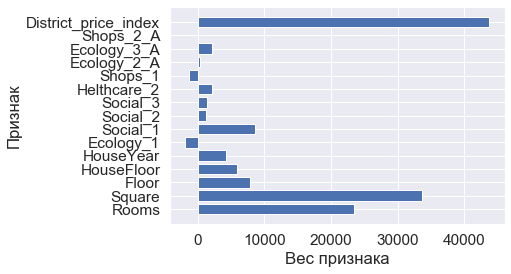

### Настройка и оценка финальной модели

**Подбор гиперпараметров**

In [ ]:
gb_model = GradientBoostingRegressor(random_state=21)
gb_model

In [ ]:
#%%time
params = {'n_estimators':[50, 100, 200], 
          'max_depth':[3, 5, 7]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X, y)

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_